# Sentiment Analysis using LDA with PCA and Stopwords Removal

In [1]:
#Libraries
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords  # List of common words usually ignored in text analysis
#from nltk.stem.porter import PorterStemmer  # For stemming using the Porter algorithm
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

## 1. Dataset

In [2]:
imdb_dataset = pd.read_csv('C:/Users/Nosse/IMDBDataset.csv') #load data
print(imdb_dataset.shape)

(50000, 2)


## 2. Review Text Pre-Processing : Cleaning Text & StopWords

In this section, we perform comprehensive text preprocessing to prepare the dataset for topic modeling and classification. As in the previous notebook, we apply several key steps: `HTML tag removal`, `special character filtering`, `tokenization`, `text normalization`, and `stemming`, which reduces words to their root forms (e.g., “running” → “run”) to unify similar terms and reduce vocabulary size.

A notable enhancement in this notebook is the **removal of stopwords**, which are common, non-informative words (such as “the”, “and”, “is”) that do not contribute significantly to sentiment or topic structure.



### 2.1 Remove HTML tags & Noise from the text

In [3]:
#remove html from text
def remove_html(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    ss = BeautifulSoup(text, "html.parser")
    return ss.get_text()
    
#remove text between square brackets
def remove_btw_square_bb(text):
    return re.sub(r'\[[^]]*\]','',text)

#call all the function to clean text
def remove_noise_txt(text):
    text = remove_html(text)
    text = remove_btw_square_bb(text)
    return text

#apply the function
imdb_dataset['review']= imdb_dataset['review'].apply(remove_noise_txt)


#### Explanation:

1. **Removing HTML from text**: the function *remove_html(text)* uses BeautifulSoup to parse HTML content from the given text and extract only text without the tags. Useful fro cleaning reviews that may contain HTML tags.
   
2. **Removing text bewtween square brackets**: the function *remove_btw_square_bb(text)* utilizes a regex (regular expression), to find and remove (replace) any text that appears between square brackets, this helps to eliminate irrelevant information.
   
3. **Removing Noise from text**: the function  *remove_noise_txt(text)* combines the two previous functions, first remove HTML tags and then eliminates text that is enclosed in square brackets.

### 2.2 Removing special CHR

In [4]:
#Function to remove special chr with regex
def remove_sp_CHR(text, remove_digits=True):
    pattern= r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Function call
imdb_dataset['review']= imdb_dataset['review'].apply(remove_sp_CHR)

#### Explanation: 

In this step, we define a function `remove_sp_CHR` that uses regular expressions (`regex`) to clean the text data. Specifically, it removes **special characters**, preserving only alphanumeric characters and whitespace. The pattern `[^a-zA-Z0-9\s]` matches any character that is **not** a letter, digit, or space, and replaces it with an empty string. This function is applied to each review in the dataset to ensure the text is cleaner and more consistent for subsequent processing.

### 2.3 Null or Duplicate values Detection (columns - rows)

In [5]:
null_var_column = imdb_dataset.isnull().sum() #null values in dataset
print("Null values - each column: \n",null_var_column)

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)

Null values - each column: 
 review       0
sentiment    0
dtype: int64

 Duplicates -  rows: 
 419



**NOTE**:

In this study, **duplicate entries are intentionally retained** in the dataset to preserve a perfectly balanced distribution between sentiment classes. By maintaining the duplicates, we ensure an equal number of **25,000 positive** and **25,000 negative** reviews. This balance helps prevent bias in model training and evaluation, allowing for fairer comparisons and more reliable performance metrics during sentiment classification.


### 2.4 Text Normalization & Tokenization

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

#download  stop-words
nltk.download('stopwords')

#Tokenization
tokenizer = ToktokTokenizer()

#List of stop-words
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nosse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NLTK Import and Stopword Download**
The code begins by importing the NLTK (Natural Language Toolkit) library, a widely used toolkit for natural language processing. It also downloads the English stopwords set  a collection of frequently occurring words like "and," "is," and "that" which are usually excluded during preprocessing due to their limited contribution to text meaning.

**Tokenizing the Text**
A tokenizer instance using ToktokTokenizer is created. Tokenization refers to splitting the text into smaller components (typically words or phrases), facilitating easier analysis and manipulation.

**Setting English Stopwords**
Using NLTK, the code defines a list of English stopwords. This enables the model to filter out these commonly used terms that don't add significant value to sentiment interpretation.

### 2.5 Optimization : Text Stemming

Stemming is a text preprocessing technique used in Natural Language Processing (NLP) to reduce words to their root or base form, known as the stem. The goal is to treat words with similar meanings (such as "running", "runs", "ran") as a single term, thereby improving the efficiency and effectiveness of text analysis.

In [7]:
#Stemming Function
def stem_txt(txt):
    Ps = nltk.porter.PorterStemmer()
    txt = ' '.join([Ps.stem(word) for word in txt.split()])
    return txt

#Apply f
imdb_dataset['review']=imdb_dataset['review'].apply(stem_txt)



**Stem_txt** : this function applies stemming to a given text using the **Porter Stemmer** from the NLTK library.
Splits the input text into individual words,applies stemming to each word using the **stem()** method.
After all, rebuilds the list of stemmed words into a single string and returns the processed (stemmed) text.

**The stem_txt() function is applied to every review in the review column of the imdb_dataset. The original review texts are replaced with their stemmed versions.**

In [8]:
#Show Stemming result on dataset
print(imdb_dataset['review'].head(10))

0    one of the other review ha mention that after ...
1    a wonder littl product the film techniqu is ve...
2    i thought thi wa a wonder way to spend time on...
3    basic there a famili where a littl boy jake th...
4    petter mattei love in the time of money is a v...
5    probabl my alltim favorit movi a stori of self...
6    i sure would like to see a resurrect of a up d...
7    thi show wa an amaz fresh innov idea in the 70...
8    encourag by the posit comment about thi film o...
9    if you like origin gut wrench laughter you wil...
Name: review, dtype: object


### 2.6 Removing stopwords

In [9]:
stop = set(stopword_list)
print("List of Stop Words to remove:\n")
print(stop)

# Function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply function on review column
imdb_dataset['review'] = imdb_dataset['review'].apply(remove_stopwords)

# Show the first 10 rows after removing stopwords
print("\n Review without Stop words:\n")
print(imdb_dataset['review'].head(10))


List of Stop Words to remove:

{'a', 'all', "you've", 'at', 'doesn', 'up', 'wasn', 'didn', 'its', "you'd", 'only', 'll', "don't", "we'll", 'if', "he'd", 'him', 'not', 'some', 'those', 't', 'yours', 'but', 'theirs', 'we', 'can', 'so', "we're", 'should', 'that', 'between', 'are', 'has', 'out', 'my', 'under', 'each', "couldn't", 'once', 'haven', "mightn't", 's', 'them', 'don', 'with', "i'm", "aren't", "i've", 'be', 'nor', 'they', 'did', 'any', 'further', "weren't", 'will', 'an', 'hadn', 'just', 'own', 'this', 'hasn', 'had', "they'd", 'than', "we'd", 'what', 'have', "it'd", "mustn't", 'me', 'am', 'ain', 'other', "doesn't", "you'll", 'was', "he's", 'is', 'o', 'where', 'after', "they've", 'for', "it's", 'there', 'then', 'it', 'on', 'her', "didn't", 'shouldn', 're', 'now', 'i', "it'll", 'do', 'before', 'until', 'as', 'were', 'm', 'or', "they'll", 'themselves', 'ma', 'ours', 'through', 'during', 'y', 'their', "shan't", 'weren', 'd', 'above', 'having', 'needn', 'from', 'yourselves', 'who', "we'

## 3.Data Split : Train set Review & Test set Review

The dataset is split into two subsets: **70%** of the data is used to train the models, while the remaining **30%** is reserved for testing and evaluating the model’s predictive performance.

In [10]:
from sklearn.model_selection import train_test_split

#Take 70% of the data for training
train_size = int(0.7 * len(imdb_dataset))

#Splitting training and testing sets
n_train_revw = imdb_dataset.review[:train_size]
n_test_revw = imdb_dataset.review[train_size:]
train_sentiments = imdb_dataset.sentiment[:train_size]
test_sentiments = imdb_dataset.sentiment[train_size:]

X_tr = n_train_revw
X_test = n_test_revw

Y_tr = train_sentiments
Y_test = test_sentiments 

#print(f"#1 TRAINING REVIEW:\n{X_tr.iloc[0]}\n")
#print(f"#1 TESTING REVIEW:\n{X_test.iloc[0]}\n")

print("Train Setiments Len: ", Y_tr.shape)
print("Test Setiments Len: ", Y_test.shape)



Train Setiments Len:  (35000,)
Test Setiments Len:  (15000,)


## 3. Applying BoW and Reducing Dimensionality on Train and Test Sets with PCA

### 3.1 BoW Matrix: Train & Test

In [13]:
# CountVectorizer
vectorizer = CountVectorizer(max_features=10000)

vector_train_rev = vectorizer.fit_transform(n_train_revw)
vector_test_rev = vectorizer.transform(n_test_revw)

print('BOW_vc_train:', vector_train_rev.shape)
print('BOW_vc_test:', vector_test_rev.shape)

BOW_vc_train: (35000, 10000)
BOW_vc_test: (15000, 10000)


### 3.2 BoW Matrix:  Data Normalization with L2 Normalization

In [14]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
X_train_bow_norm = normalizer.fit_transform(vector_train_rev)
X_test_bow_norm = normalizer.transform(vector_test_rev)


### 3.3 BoW : PCA on Train & Test Data

In [15]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=100)
X_train_pca_bow = pca.fit_transform(X_train_bow_norm.toarray())
X_test_pca_bow = pca.transform(X_test_bow_norm.toarray())

#### PCA 2D Visualization for BoW

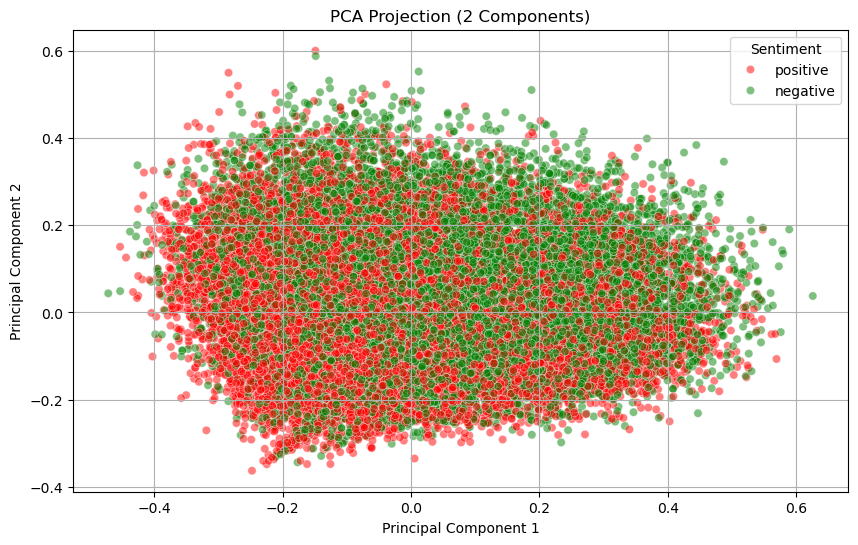

In [17]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_bow_norm.toarray())

# Visualizza con le etichette
pca_df = pd.DataFrame(data=X_train_pca_vis, columns=['PC1', 'PC2'])
pca_df['Sentiment'] = Y_tr 

plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sentiment', palette=['red','green'], alpha=0.5)
plt.title('PCA Projection (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## 4. Applying TFIDF and Reducing Dimensionality on Train and Test Sets with PCA

### 4.1 TFIDF Matrix: Train & Test

In [18]:
#Def. TfidfVectorizer
tfidf= TfidfVectorizer(max_features=10000)

#Tfidf Train set
tfidf_train_data = tfidf.fit_transform(n_train_revw)

#Tfidf Test set
tfidf_test_data = tfidf.transform(n_test_revw)

print('Tfidf_train:', tfidf_train_data.shape)
print('Tfidf_test:', tfidf_test_data.shape)

Tfidf_train: (35000, 10000)
Tfidf_test: (15000, 10000)


### 4.2 TFIDF Matrix:  Data Normalization with L2 Normalization

In [19]:
normalizer = Normalizer()
X_train_tfidf_norm = normalizer.fit_transform(tfidf_train_data)
X_test_tfidf_norm = normalizer.transform(tfidf_test_data)

### 4.3 TFIDF : PCA on Train & Test Data

In [22]:
# PCA
pca = PCA(n_components=100)
X_train_pca_tfidf = pca.fit_transform(X_train_tfidf_norm.toarray())
X_test_pca_tfidf = pca.transform(X_test_tfidf_norm.toarray())

#### PCA 2D Visualization for TFIDF

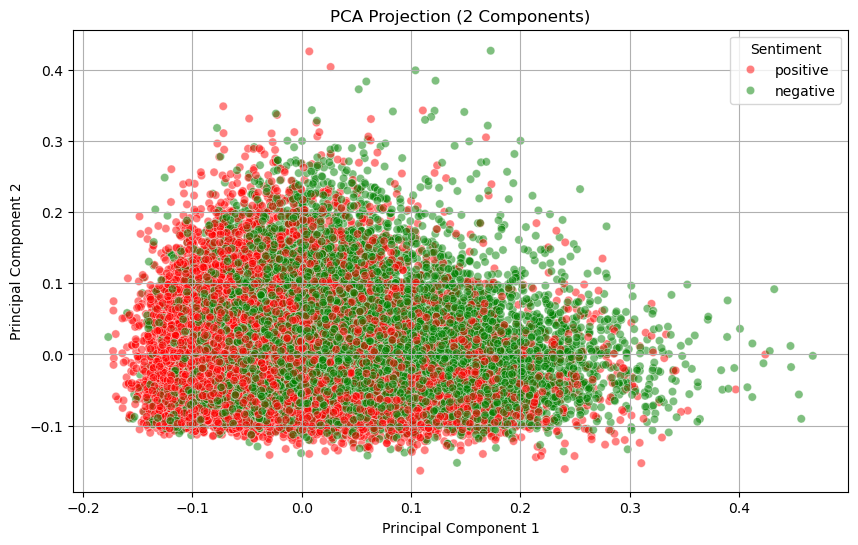

In [23]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_tfidf_norm.toarray())

# Visualizza con le etichette
pca_df = pd.DataFrame(data=X_train_pca_vis, columns=['PC1', 'PC2'])
pca_df['Sentiment'] = Y_tr 

plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sentiment', palette=['red','green'], alpha=0.5)
plt.title('PCA Projection (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()